# MBHB Astrometric Calculator for Sources
A simple notebook to exercise the MBHB waveform code to compute SNR, SNR vs. time, and resolution vs. time. This version does one concept and many sources

To run this on Google Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/binaryResolutionSources.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
    
# Import
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(src)
import constants
import metrics
import sources
import concepts
import subsystems
import background

### Define the concept
Here we load in one of the pre-defined concepts, or you can define your own

In [2]:
model = concepts.LISACBE.copy()
modelName = model.get('label')
model = background.add2model(model)     # add galactic background model

### Define the sources
Here we load in some pre-defined target sources

In [3]:
# list of concepts by name
sourceNames = (
    'MBHB81',
    'MBHB73',
    'MBHB61',
    'MBHB31',
    'IMBH413',
    'SOBH')

sourceList = list()
for s in sourceNames:
    source = eval('sources.%s' % s).copy()         # load the source
    sourceList.append(source)                  # add the source to list
    

### Perform the observations
We first compute the SNR and then the angular resolution

In [4]:
obs = list()
for s in sourceList:
    ob = metrics.getSourceSnr(s,model,-4.0*constants.year)
    ob = metrics.getResolution(ob)
    obs.append(ob)
    

### Make some plots

#### Plot sensitivity curves and waveform
Here we scale the waveform by delta-f, which is probably not quite right

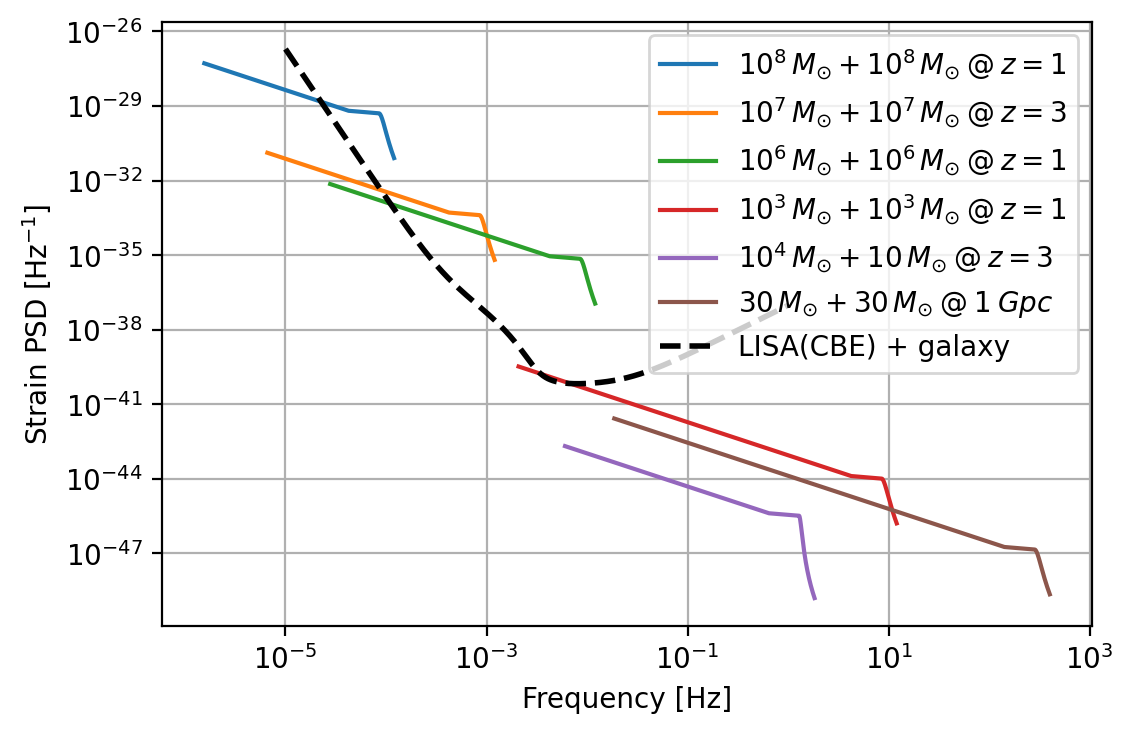

In [5]:
# sensitivity plot
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
f = np.logspace(-5,0,1000)
for ob in obs:
    ax.plot(ob.get('f')[1:],np.abs(ob.get('h')[1:]**2)*np.diff(ob.get('f')),linestyle='-',label=ob.get('source').get('label'))
 
ax.plot(f,metrics.makeSensitivity(f,ob.get('model')),color = 'black', linewidth=2.0,linestyle='--',label=ob.get('model').get('label'))


ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain PSD [Hz$^{-1}$]')
plt.legend()
ax.grid(True)
plt.savefig('../plots/%s_source_sensitvities.png' % modelName)

#### SNR as a function of time plot

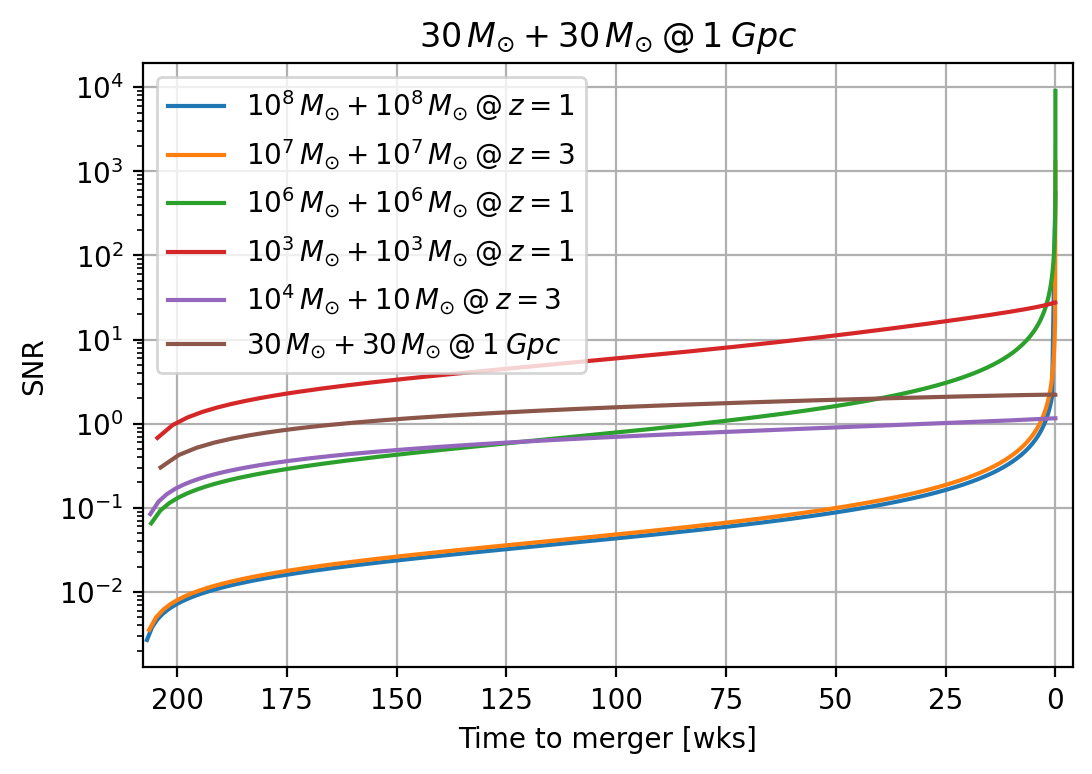

In [6]:
# SNR of time plot
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
for ob in obs:
    ax.plot(-ob.get('t')*52/constants.year,ob.get('SNR of t'),linestyle='-',label=ob.get('source').get('label'))

plt.xlim([-ob.get('t')[0]*52/constants.year+4,-4])
plt.title(ob.get('source').get('label'))
ax.set_xscale('linear')
ax.set_yscale('log')
plt.xlabel('Time to merger [wks]')
plt.ylabel(r'SNR')
plt.legend()
ax.grid(True)
plt.savefig('../plots/%s_snr_v_t.png' % modelName)

#### Angular resolution as a function of time

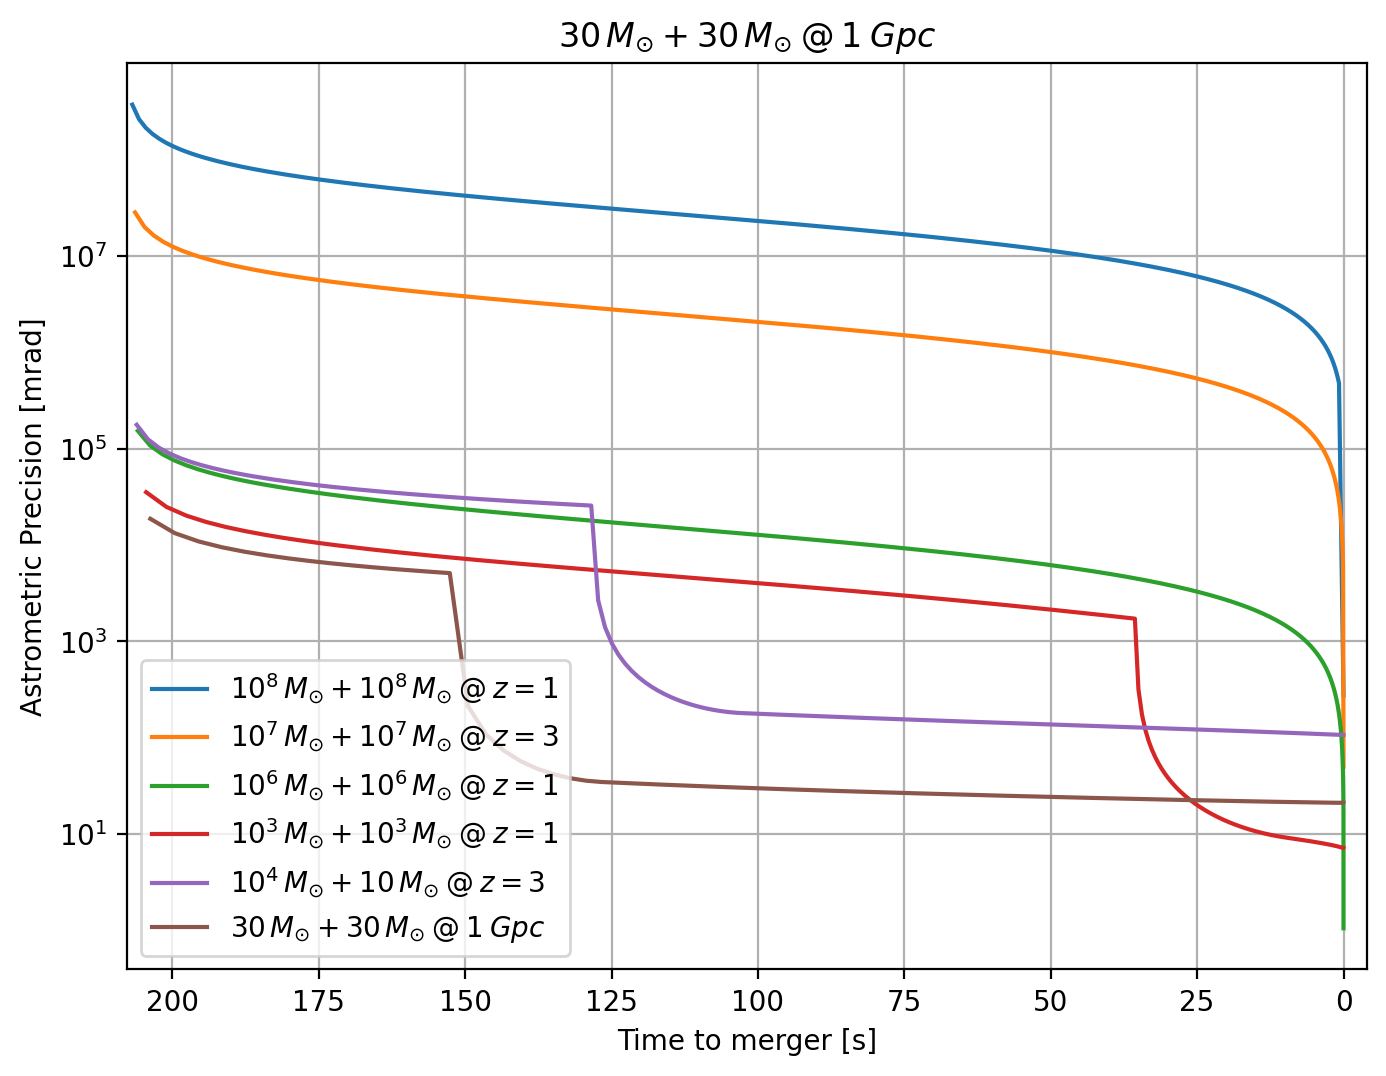

In [7]:
# Angular resolution
fig = plt.figure(figsize=[8,6],dpi=200)
ax = fig.add_subplot(1,1,1)
for ob in obs:
    ax.plot(-ob.get('t')*52/constants.year,ob.get('Angular Resolution')*1e3,label= ob.get('source').get('label'))
plt.xlim([-ob.get('t')[0]*52/constants.year+4,-4])
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.xlabel('Time to merger [s]')
plt.ylabel('Astrometric Precision [mrad]')
plt.title(ob.get('source').get('label'))
plt.savefig('../plots/%s_res_v_t.png' % modelName)

### Make a table of the results

In [8]:
import pandas as pd

In [9]:
t_table = 0 # time before merger for generating table
t = obs[0].get('t')
i_table = np.clip(np.argmin(np.abs(t-t_table)),0,np.size(t)-1)
names = list()
SNRs = list()
res = list()
obtimes = list()
for ob in obs:
    names.append(ob.get('source').get('label'))
    SNRs.append(ob.get('SNR of t')[i_table])
    res.append(ob.get('Angular Resolution')[i_table]/1e-3)
    obtimes.append(-(ob.get('observation time')-t_table)*365/constants.year)

df = pd.DataFrame(index = names, data = {
    'SNR' : SNRs,
    'Angular Resolution [mrad]' : res,
    'Observation Time [days]' : obtimes
})

df['Angular Resolution [arcsec]']= df['Angular Resolution [mrad]']*1e-3*180/np.pi*3600
df[['SNR', 'Observation Time [days]', 'Angular Resolution [mrad]', 'Angular Resolution [arcsec]']]
    

,SNR,Observation Time [days],Angular Resolution [mrad],Angular Resolution [arcsec]
"$10^{8}\,M_{\odot}+10^{8}\,M_{\odot}\:@\:z=1$",554.547346,5.392102,275.409702,56807.328761
"$10^{7}\,M_{\odot}+10^{7}\,M_{\odot}\:@\:z=3$",1286.811073,1.287424,50.040489,10321.591779
"$10^{6}\,M_{\odot}+10^{6}\,M_{\odot}\:@\:z=1$",9040.284552,44.804850,1.050520,216.685371
"$10^{3}\,M_{\odot}+10^{3}\,M_{\odot}\:@\:z=1$",27.749124,410.951229,7.150754,1474.948855
"$10^{4}\,M_{\odot}+10\,M_{\odot}\:@\:z=3$",1.159034,0.139215,106.648365,21997.804426
"$30\,M_{\odot}+30\,M_{\odot}\:@\:1\:Gpc$",2.215527,0.000002,21.106438,4353.515442
